In [1]:
#import 모듈
import time   #시간 딜레이 위한 모듈
from subprocess import Popen
import pyperclip #복사를 위한 모듈
import pyautogui #키보드 마우스 자동화를 위한 모듈

#정보 수집을 위한 모듈
import webbrowser as wb
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

#그래프 그리기 위한 모듈
import matplotlib.pyplot as plt

In [2]:
#기초 list 설정
result_mes=[]   #메일 내용용 리스트
month=['8','9','10','11','12','1','2','3','4','5']   #축구 시즌 달 리스트
#축구 팀 명단 리스트 (승격 및 강등시 팀명 확인 후 바꾸어 주면 된다.)
Epl_teamList = [
        "맨시티",
        "리버풀",
        "첼시",
        "토트넘",
        "아스널",
        "맨유",
        "웨스트햄",
        "레스터",
        "브라이튼",
        "울버햄튼",
        "뉴캐슬",
        "팰리스",
        "브렌트포드",
        "아스톤 빌라",
        "사우샘프턴",
        "애버턴",
        "리즈",
        "번리",
        "왓포드",
        "노리치"
    ]
#승 , 무, 패
team_win= []
team_draw=[]
team_lose=[]
#득점, 실점, 골득실차
team_goal_for=[]
team_goal_against=[]
team_goal_difference=[]
#매달마다 득점, 실점, 골득실차
monthly_goal_for=[]
monthly_goal_against=[]
monthly_goal_difference=[]
#누적 득점, 실점, 골득실차
accumulate_goal_for=[]
accumulate_goal_against=[]
accumulate_goal_difference=[]
#총 게임수 38게임(EPL은 20팀으로 고정)
game_num=[]
def set_game_num():   #1부터 38까지 리스트로 저장 => 나중에 graph 그릴때 사용
    for i in range(1,38+1):
        game_num.append(i)

In [3]:
def reset():   #다른팀을 확인해보고 싶으면 reset 누르고 다시 시작하면 된다.
    result_mes.clear()   #메일 내용용 리스트
    game_num.clear()
    #승 , 무, 패
    team_win.clear()
    team_draw.clear()
    team_lose.clear()
    #득점, 실점, 골득실차
    team_goal_for.clear()
    team_goal_against.clear()
    team_goal_difference.clear()
    #매달마다 득점, 실점, 골득실차
    monthly_goal_for.clear()
    monthly_goal_against.clear()
    monthly_goal_difference.clear()
    #누적 득점, 실점, 골득실차
    accumulate_goal_for.clear()
    accumulate_goal_against.clear()
    accumulate_goal_difference.clear()

In [4]:
#프로그램 설명 =>메모장과 출력창에 프로그램 설명 띄우기
def help_program(): 
    print(f'이 프로그램은 원하는 EPL 팀의 정보(승,무,패,승률,득점,실점,골득실차)를 이메일로 전송받아서 한 눈에 확인하는 프로그램입니다.\n우선 선택할 팀명을 확인 후, 원하는 팀명숫자를 입력하세요.\n그후 본인 이메일을 통해 정보를 입력하고 보낼 주소를 입력하고 프로그램은 끝이납니다.')
    time.sleep(1) # 1초 대기
    Popen('notepad')  # 메모장을 실행한다.
    time.sleep(1) # 1초 대기
    pyautogui.hotkey('win','up',interval=0.5)
    
    #도움말
    first_mes='''이 프로그램은 원하는 EPL 팀의 정보(승,무,패,승률,득점,실점,골득실차)를 이메일로 전송받아서 한 눈에 확인하는 프로그램입니다.\n우선 선택할 팀명을 확인 후, 원하는 팀명숫자를 입력하세요.\n그후 본인 이메일을 통해 정보를 입력하고 보낼 주소를 입력하고 프로그램은 끝이납니다.

'''
    # 메모장은 \r\n을 줄바꿈 코드로 인식하므로 replace가 필요하다
    first_mes = first_mes.replace('\n', '\r\n')
    time.sleep(1) # 1초 대기
    copy_memo(first_mes)
    #pyperclip.copy(first_mes)
    #pyautogui.hotkey('ctrl', 'v')
    
    #print_EPL_teamList()
    cnt_help=1
    for i in Epl_teamList:
        copy_memo(cnt_help)
        copy_memo(i)
        copy_memo('\n')
        print(f'{cnt_help} {i}')  #출력창에 순서와 팀명 띄우기
        cnt_help = cnt_help+1
    team_numb = int(input(''))   #팀명 순서 입력하기 (나중에 순서로 팀명설정)
    return team_numb

def print_EPL_teamList():
    for i in Epl_teamList:
        print(i)  
def copy_memo(mes):
    # 클립보드에 메시지를 복사한다
    pyperclip.copy(mes)
    # 클립보드에서 메시지를 가져다 붙여넣기 한다
    pyautogui.hotkey('ctrl', 'v')
    time.sleep(0.1)


In [5]:
#한달동안 경기정보 수집 및 정리
def collect_data():
    monthly_goal=0   #한달동안 득점
    monthly_loss=0   #한달동안 실점
    monthly_diff=0   #한달동안의 득실차
    ele_name = driver.find_elements_by_class_name("name")   #class 가 name을 ele_name에 저장 (ex:맨시티,리버풀..)
    ele_score = driver.find_elements_by_class_name("score") #class가 score을 ele_score에 저장 (ex: 4,0..)
    name_idx=0
    
    list_name_idx=[]
    for i in ele_name:
        if(i.text==team_name):   #해당 팀의 경기이면 (ex: 1번 맨시티의 경기이면)
            list_name_idx.append(name_idx)   #ele_name에 저장되어 있는 팀명의 위치를 찾아 위치저장
        name_idx+=1
   
    goal=0   #득점
    loss=0   #실점
    for i in list_name_idx:   #해당 팀의 위치를 가져온다. (홈일 경우와 어웨이일 경우 다르게 계산해야함)
        goal= int(ele_score[i].text)   #해당 팀이 넣은 골의 수를 가져온다.
        team_goal_for.append(goal)     #해당 팀이 넣은 골을 team_goal_for 리스트에 저장
        if(i%2 ==0):   #짝수이면 홈팀. 상대 팀은 어웨이이고 +1을 해서 상대팀골을 구한다. 
            loss = int(ele_score[i+1].text)
            team_goal_against.append(loss)   #해당 팀이 먹힌 골 수를 team_goal_against 리스트에 저장
        elif(i%2==1):  #홀수이면 어웨이팀,상대 팀은 홈이며 -1 해서 상대팀 골을 구한다.
            loss = int(ele_score[i-1].text)
            team_goal_against.append(loss)
            
        team_goal_difference.append(goal - loss)   #골득실차 team_goal_difference 리스트에 저장
        
        if(goal>loss): #승리
            team_win.append(1)
        elif(loss>goal):  #패배
            team_lose.append(1)
        elif(goal==loss):  #무승부
            team_draw.append(1)
        
        #한달동안 득점, 실점, 득실차 계산
        monthly_goal= monthly_goal + goal
        monthly_loss= monthly_loss + loss
        monthly_diff= monthly_goal - monthly_loss
    
    #한달동안 득점, 실점, 득실차를 리스트에 저장 (리스트는 monthly를 붙여서 표현)
    monthly_goal_for.append(monthly_goal)
    monthly_goal_against.append(monthly_loss)
    monthly_goal_difference.append(monthly_diff)

#누적 득점, 실점, 득실차를 구하기 위한 함수들
def count_month_goal_for():  #누적 득점을 accumulate_goal_for 리스트에 저장
    sum=0
    for i in monthly_goal_for:
        sum =sum + int(i)
        accumulate_goal_for.append(sum)
    return sum

def count_month_goal_against():  #누적 실점을 accumulate_goal_against 리스트에 저장
    sum=0
    for i in monthly_goal_against:    
        sum =sum + int(i)
        accumulate_goal_against.append(sum)
    return sum

def count_month_goal_difference():  #누적 골득실차를 accumulate_goal_difference 리스트에 저장
    sum=0
    for i in monthly_goal_difference:
        sum =sum + int(i)
        accumulate_goal_difference.append(sum)
    return sum

#위에 count 함수들을 한번에 실행하기 위한 counting_ALL 함수
def counting_ALL():
    set_game_num()   #경기수 38을 리스트로 설정
    count_month_goal_for()
    count_month_goal_against()
    count_month_goal_difference()
    print(f'Done counting ALL data')  #진행상황 출력

#한달 결과 간단하게 출력하기 (ex: 8월 : 10 - 1 = 9 )
def monthly_result(i):
    print(f'{month[i]}월: {monthly_goal_for[i]}득점 - {monthly_goal_against[i]}실점 = {monthly_goal_difference[i]}골득실')

def print_list(): #확인용도로 사용, 검증단계에서만 사용
    print(monthly_goal_for)
    print(monthly_goal_against)
    print(monthly_goal_difference)
    print(accumulate_goal_for)
    print(accumulate_goal_against)
    print(accumulate_goal_difference)

In [6]:
#모든 시즌 정보수집
def exe_collection():
    b_month = driver.find_elements_by_class_name("_month_list_btn")  #b_month 설정. b_month에는 시즌 달이 저장되어있다. (8월,9월,10월..)
    cnts=0
    for i in b_month:
        b_month = driver.find_elements_by_class_name("_month_list_btn")  #click()후 다시 설정해줘야 한다.
        b_month[cnts].click()   #해당 달로 이동, 처음달부터 진행
        time.sleep(1)
        collect_data()   #한달 정보수집
        print(f"{month[cnts]}월: done collecting_data")   #수집완료 메세지 출력
        monthly_result(cnts)   #수집한 한달 정보출력
        cnts=cnts+1   #다음달로 넘어가기 위해 필요
    final_analysis()  #승무패 결과와, 승률표현
    graph_data()      #그래프 그리기
        
#승무패 계산
def print_win_draw_lose():
    result_mes.append(f'팀명은 {team_name} 입니다.\n')
    result_mes.append(f"\n\n*****************\n"+f'승 :{number_of_win()}  무: {number_of_draw()}  패: {number_of_lose()}\n')
    print(f'승 :{number_of_win()}  무: {number_of_draw()}  패: {number_of_lose()} ')
    return str
#승리경기 수 계산    
def number_of_win():
    num_win=0
    for i in team_win:
        num_win = num_win + i
    return num_win
#비긴경기 수 계산
def number_of_draw():
    num_draw=0
    for i in team_draw:
        num_draw = num_draw + i   
    return num_draw
#패배경기 수 계산
def number_of_lose():
    num_lose=0
    for i in team_lose:
        num_lose = num_lose + i
    return num_lose    
        
#경기수 
def total_match():
    total_match_number=number_of_win() + number_of_draw() + number_of_lose()
    return total_match_number
#승률 계산
def win_rate():
    p_win_rate=number_of_win()/total_match() *100
    return p_win_rate

#승무패 결과와, 승률표현
def final_analysis():
    counting_ALL()
    print(f'\n\n*****************')
    print_win_draw_lose()
    print(f'승률은 {win_rate()}입니다.')
    print(f'*****************')
    result_mes.append(f'승률은 {win_rate()}입니다.\n'+"*****************\n")  #메일 내용으로 리스트에 저장


In [7]:
#그래프 표현하기 위해 축 설정용 리스트 설정
set_plt_list=[accumulate_goal_for, monthly_goal_for, team_goal_for,
              accumulate_goal_against, monthly_goal_against, team_goal_against,
              accumulate_goal_difference, monthly_goal_difference, team_goal_difference]
set_plt_name=["accumulate_goal_for", "monthly_goal_for", "team_goal_for",
              "accumulate_goal_against", "monthly_goal_against", "team_goal_against",
              "accumulate_goal_difference", "monthly_goal_difference", "team_goal_difference"]
set_plt_ylabel=["goal","loss","difference"]
set_plt_xlabel=["game number","month"]

#수집한 data를 matplotlib로 그래프 그리기
def graph_data():
    for i in range(9):
        if(i==2 or i==5 or i==8):
            set_plt_all(i,i%3)
        else:
            set_plt(i,i%3)
#달마다 그래프로 확인    
def set_plt(number,y):
    savefig_name=team_name+"_"+str(set_plt_name[number])
    plt.plot(month,set_plt_list[number],marker='o')
    plt.title(f'{set_plt_name[number]}')
    plt.xlabel('month')
    plt.ylabel(set_plt_ylabel[y])   #0-gaol, 1-loss, 2-difference
    plt.savefig(f'./{savefig_name}.jpg')
    plt.show()
    print(set_plt_list[number])
    
#전체 경기수로 확인    
def set_plt_all(number,y):
    savefig_name=team_name+"_"+str(set_plt_name[number])
    plt.plot(game_num,set_plt_list[number],marker='o')
    plt.title(f'{set_plt_name[number]}')
    plt.xlabel('game number')
    plt.ylabel(set_plt_ylabel[y])   #0-gaol, 1-loss, 2-difference
    plt.savefig(f'./{savefig_name}.jpg')
    plt.show()
    print(set_plt_list[number])   


이 프로그램은 원하는 EPL 팀의 정보(승,무,패,승률,득점,실점,골득실차)를 이메일로 전송받아서 한 눈에 확인하는 프로그램입니다.
우선 선택할 팀명을 확인 후, 원하는 팀명숫자를 입력하세요.
그후 본인 이메일을 통해 정보를 입력하고 보낼 주소를 입력하고 프로그램은 끝이납니다.
1 맨시티
2 리버풀
3 첼시
4 토트넘
5 아스널
6 맨유
7 웨스트햄
8 레스터
9 브라이튼
10 울버햄튼
11 뉴캐슬
12 팰리스
13 브렌트포드
14 아스톤 빌라
15 사우샘프턴
16 애버턴
17 리즈
18 번리
19 왓포드
20 노리치
1


선택한 팀은 맨시티


C:\Users\pc\AppData\Local\Temp/ipykernel_25412/1631235443.py:3: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  b_month = driver.find_elements_by_class_name("_month_list_btn")  #b_month 설정. b_month에는 시즌 달이 저장되어있다. (8월,9월,10월..)
C:\Users\pc\AppData\Local\Temp/ipykernel_25412/1631235443.py:6: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  b_month = driver.find_elements_by_class_name("_month_list_btn")  #click()후 다시 설정해줘야 한다.
C:\Users\pc\AppData\Local\Temp/ipykernel_25412/321094729.py:7: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  ele_score = driver.find_elements_by_class_name("score") #class가 score을 ele_score에 저장 (ex: 4,0..)


8월: done collecting_data
8월: 10득점 - 1실점 = 9골득실
9월: done collecting_data
9월: 2득점 - 0실점 = 2골득실
10월: done collecting_data
10월: 8득점 - 5실점 = 3골득실
11월: done collecting_data
11월: 7득점 - 1실점 = 6골득실
12월: done collecting_data
12월: 24득점 - 5실점 = 19골득실
1월: done collecting_data
1월: 4득점 - 2실점 = 2골득실
2월: done collecting_data
2월: 9득점 - 3실점 = 6골득실
3월: done collecting_data
3월: 4득점 - 1실점 = 3골득실
4월: done collecting_data
4월: 12득점 - 3실점 = 9골득실
5월: done collecting_data
5월: 19득점 - 5실점 = 14골득실
Done counting ALL data


*****************
승 :29  무: 6  패: 3 
승률은 76.31578947368422입니다.
*****************


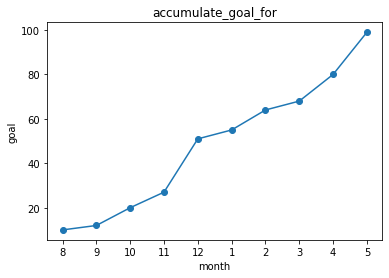

[10, 12, 20, 27, 51, 55, 64, 68, 80, 99]


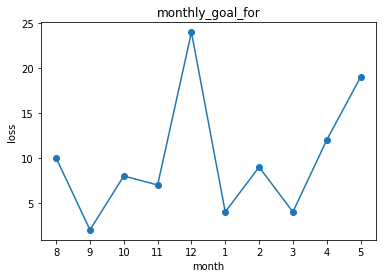

[10, 2, 8, 7, 24, 4, 9, 4, 12, 19]


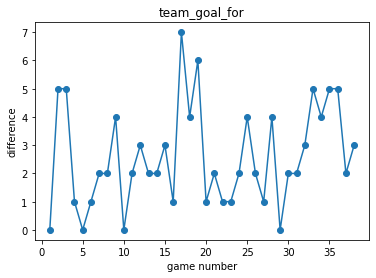

[0, 5, 5, 1, 0, 1, 2, 2, 4, 0, 2, 3, 2, 2, 3, 1, 7, 4, 6, 1, 2, 1, 1, 2, 4, 2, 1, 4, 0, 2, 2, 3, 5, 4, 5, 5, 2, 3]


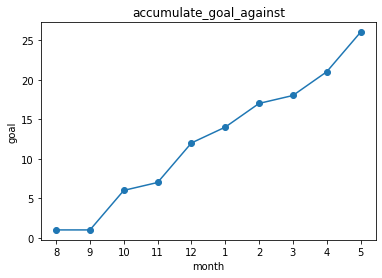

[1, 1, 6, 7, 12, 14, 17, 18, 21, 26]


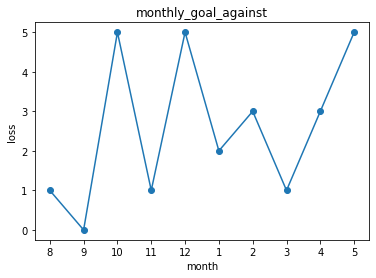

[1, 0, 5, 1, 5, 2, 3, 1, 3, 5]


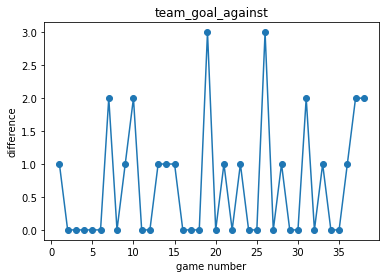

[1, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 1, 1, 1, 0, 0, 0, 3, 0, 1, 0, 1, 0, 0, 3, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 2, 2]


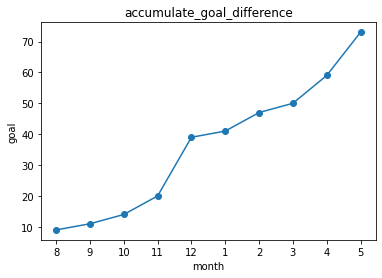

[9, 11, 14, 20, 39, 41, 47, 50, 59, 73]


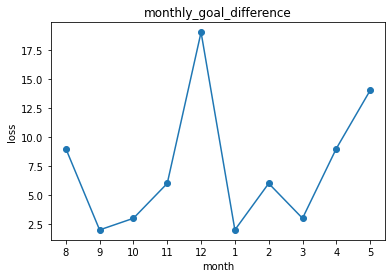

[9, 2, 3, 6, 19, 2, 6, 3, 9, 14]


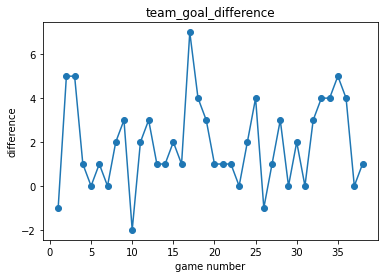

[-1, 5, 5, 1, 0, 1, 0, 2, 3, -2, 2, 3, 1, 1, 2, 1, 7, 4, 3, 1, 1, 1, 0, 2, 4, -1, 1, 3, 0, 2, 0, 3, 4, 4, 5, 4, 0, 1]


In [8]:
#START
#크롬으로 사이트 경로 설정
sport_result_site= "https://sports.news.naver.com/wfootball/schedule/index"
chrome_path = 'C:/Program Files/Google/Chrome/Application/chrome.exe'    
#설명서를 보여주며 선택할 팀 숫자를 입력받는다.
reset()
team_number=help_program()

#사이트 열기
driver = webdriver.Chrome('chromedriver')
driver.get(url=sport_result_site)
pyautogui.hotkey('win','up',interval=0.5)
#팀 선택
team_name= Epl_teamList[team_number-1]
print(f'\n\n선택한 팀은 {team_name}')   #확인용 메세지 출력

exe_collection() #수집작업 실행

In [9]:
#이메일보내기
import smtplib
import getpass  #비밀번호 가리기용 모듈
import imghdr
from email.message import EmailMessage

In [10]:
#로그인 정보와 보낼 이메일주소 입력받기
my_naver_id=input('네이버 계정을 입력하세요: ')
my_naver_ps=getpass.getpass('네이버 계정의 비밀번호를 입력하세요: ')
receiver_emailaddr=input('전송할 이메일 계정을 입력하세요: ')
#연결 설정
smtp = smtplib.SMTP('smtp.naver.com',587)
#smtp.ehlo()
#smtp.starttls()

네이버 계정을 입력하세요: ohsj0724@naver.com
네이버 계정의 비밀번호를 입력하세요: ········
전송할 이메일 계정을 입력하세요: tfy203@gmail.com


In [11]:
#이메일에 이미지 첨부함수
def make_images():
    for i in range(9):   #저장된 그래프 수만큼 (형식지정해서 9로 고정)
        i_name=team_name+"_"+set_plt_name[i]
        with open(f'{i_name}.jpg',"rb") as image:   #이미지 열기
            image_file = image.read()

        image_type = imghdr.what('codelion',image_file)
        message.add_attachment(image_file,maintype='image',subtype=image_type)   #이미지 첨부
        

#메일 내용작성 설정        
contents= ""
for i in result_mes:
    contents=contents+str(i)
    
message = EmailMessage()
message.set_content(contents)
message["Subject"] = input(f'제목을 입력하세요: ') #제목 ex: epl 분석 프로그램 결과
message["From"] = my_naver_id
message["To"] = receiver_emailaddr   

제목을 입력하세요: 2017202052_오승준_파이썬기초프로그래밍_기말과제


In [12]:
#로그인 후 메일 전송 후 종료
smtp = smtplib.SMTP('smtp.naver.com',587)
smtp.ehlo()
smtp.starttls()
smtp.login(my_naver_id,my_naver_ps)
make_images()
smtp.send_message(message)
smtp.quit()   #종료

(221, b'2.0.0 Closing connection 6U-+XeKDQVqbee8LP1-YnQ - nsmtp')

In [34]:
test